## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [ ]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [ ]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
4504351,411699,12542,105,6362,100.0
2292906,538095,4239,123,1557,27.0
3561493,758244,14282,147,503,8.0
586255,930256,14526,124,38,0.0
2811883,947922,734,135,1801,19.0


Сделаем разбиение по времени

<Axes: >

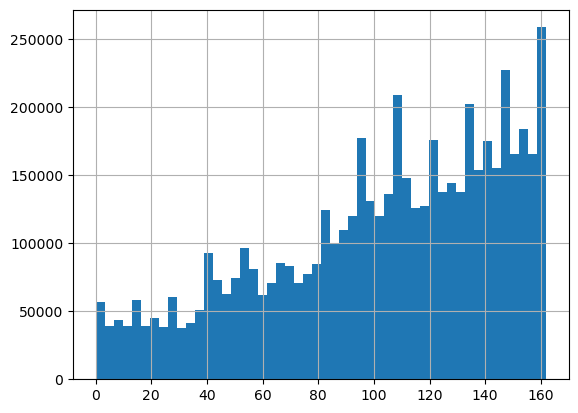

In [ ]:
df.last_watch_dt.hist(bins=50)

In [ ]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [ ]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [ ]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [ ]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
123,514235,8391,147,3570,57.0
150,179618,9988,121,6811,100.0
151,648287,7612,133,2396,36.0
186,450102,3130,85,682,9.0
191,729106,14961,152,3625,57.0


In [ ]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

,user_id,train_interactions
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5..."
1,109,"[(11047, 146)]"
2,189,"[(5505, 144)]"
3,373,"[(2154, 120)]"
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863..."


In [ ]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337..."
1,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]"
2,189,"[(5505, 144)]","[(12360, 155), (6898, 155), (4549, 160), (582,..."
3,373,"[(2154, 120)]","[(3734, 157)]"
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]"


In [ ]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[8005, 11991, 297]"
1,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]","[8005, 11991, 297]"
2,189,"[(5505, 144)]","[(12360, 155), (6898, 155), (4549, 160), (582,...","[8005, 11991, 297]"
3,373,"[(2154, 120)]","[(3734, 157)]","[8005, 11991, 297]"
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8005, 11991, 297]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [ ]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    gt_items = np.array(gt_items)
    predictions = np.array(predictions)
    if topn is None:
        topn = len(predictions)
    preds_topn = predictions[:topn]
    relevance = np.in1d(preds_topn, gt_items).astype(np.float32)
    if gt_items.size == 0:
        return 0
    cumsum_relevance = np.cumsum(relevance)
    positions = np.arange(1, topn + 1, dtype=np.float32)
    precision_at_i = cumsum_relevance / positions
    denominator = min(topn, len(gt_items))
    ap = (relevance * precision_at_i).sum() / denominator
    return ap

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    gt_items = np.array(gt_items)
    predictions = np.array(predictions)
    if topn is None:
        topn = len(predictions)
    preds_topn = predictions[:topn]
    relevance = np.in1d(preds_topn, gt_items).astype(np.float32)
    relevant_indices = np.where(relevance == 1)[0]
    if relevant_indices.size == 0:
        return 0
    first_relevant_rank = relevant_indices[0] + 1
    return 1/first_relevant_rank

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int] = None
):
    gt_items = np.array(gt_items)
    predictions = np.array(predictions)
    if topn is None:
        topn = len(predictions)
    preds_topn = predictions[:topn]
    relevance = np.in1d(preds_topn, gt_items).astype(np.float32)
    if relevance.sum() > 0:
        return 1
    else:
        return 0

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [ ]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [ ]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):
    n_users = len(df)
    gt_lists = df[gt_col].apply(lambda lst: [x[0] for x in lst]).tolist()
    preds = df[model_preds].tolist()
    topn = len(preds[0])
    preds_matrix = np.array(preds)
    relevance = np.array([np.isin(preds_matrix[i], gt_lists[i]).astype(np.float32) for i in range(n_users)])

    gt_counts = np.array([len(gt) for gt in gt_lists])

    cumsum_rel = np.cumsum(relevance, axis=1)
    positions = np.arange(1, topn + 1, dtype=np.float32)
    precision_at_i = cumsum_rel / positions[None, :]
    norm = np.minimum(topn, gt_counts)
    norm_safe = np.where(norm == 0, 1, norm).astype(np.float32)

    AP = (relevance * precision_at_i).sum(axis=1) / norm_safe
    AP = np.where(gt_counts == 0, 0, AP)

    first_rel_pos = np.full(n_users, topn+1, dtype=np.int32)
    for i in range(n_users):
        rel_idx = np.where(relevance[i] == 1)[0]
        if rel_idx.size:
            first_rel_pos[i] = rel_idx[0] + 1
    RR = 1 / first_rel_pos.astype(np.float32)
    RR = np.where(first_rel_pos > topn, 0, RR)
    HR = (relevance.sum(axis=1) > 0).astype(np.float32)
    metrics = {'map': np.mean(AP), 'mrr': np.mean(RR), 'hr': np.mean(HR) }
    return metrics

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [ ]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 8.333334e-05, 'mrr': 0.00025, 'hr': 0.0003}

In [ ]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
1,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
2,189,"[(5505, 144)]","[(12360, 155), (6898, 155), (4549, 160), (582,...","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
3,373,"[(2154, 120)]","[(3734, 157)]","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [ ]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.064668186, 'mrr': 0.1184702, 'hr': 0.2739}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [ ]:
class TopPopular:
    def __init__(self):
        self.trained = False

    def fit(self, df, col='train_interactions'):
        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                counts[item] = counts.get(item, 0) + 1
        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10) -> List[List[int]]:
        assert self.trained
        return [self.recommenations[:topn]] * len(df)

class TopPopularWeighted(TopPopular):
    def __init__(self, min_window: int):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        global_max = max(max(t for _, t in row[col]) for _, row in df.iterrows())
        threshold = global_max - self.min_window
        counts = {}
        for _, row in df.iterrows():
            for item, t in row[col]:
                if t >= threshold:
                    counts[item] = counts.get(item, 0) + 1
        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        self.recommenations = [x[0] for x in counts]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

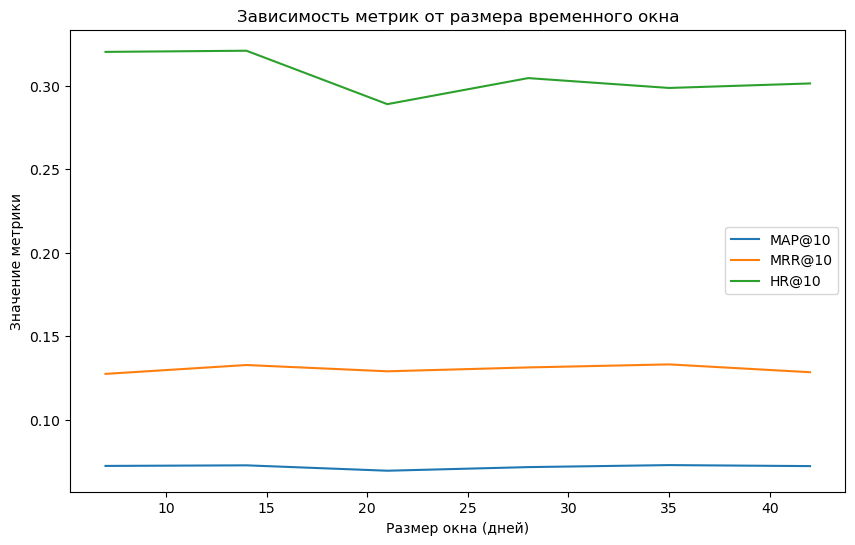

In [ ]:
windows = [7, 14, 21, 28, 35, 42]
metrics_window = {'map': [], 'mrr': [], 'hr': []}

for w in windows:
    tpw = TopPopularWeighted(min_window=w)
    tpw.fit(joined)
    joined['tpw_recs'] = tpw.predict(joined, topn=10)
    m = evaluate_recommender(joined, model_preds='tpw_recs')
    metrics_window['map'].append(m['map'])
    metrics_window['mrr'].append(m['mrr'])
    metrics_window['hr'].append(m['hr'])

plt.figure(figsize=(10, 6))
plt.plot(windows, metrics_window['map'], label='MAP@10')
plt.plot(windows, metrics_window['mrr'], label='MRR@10')
plt.plot(windows, metrics_window['hr'], label='HR@10')
plt.xlabel('Размер окна (дней)')
plt.ylabel('Значение метрики')
plt.legend()
plt.title('Зависимость метрик от размера временного окна')
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** Если окно слишком узкое, то в нём может оказаться недостаточно взаимодействий. Это приводит к тому, что статистика популярности становится шумной, поскольку малое число событий не позволяет надёжно оценить тренды. При слишком широком окне в расчёт попадают устаревшие взаимодействия, которые уже не отражают актуальные предпочтения пользователей. Идеальное значение окна должно обеспечивать баланс между количеством данных и их актуальностью

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [ ]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

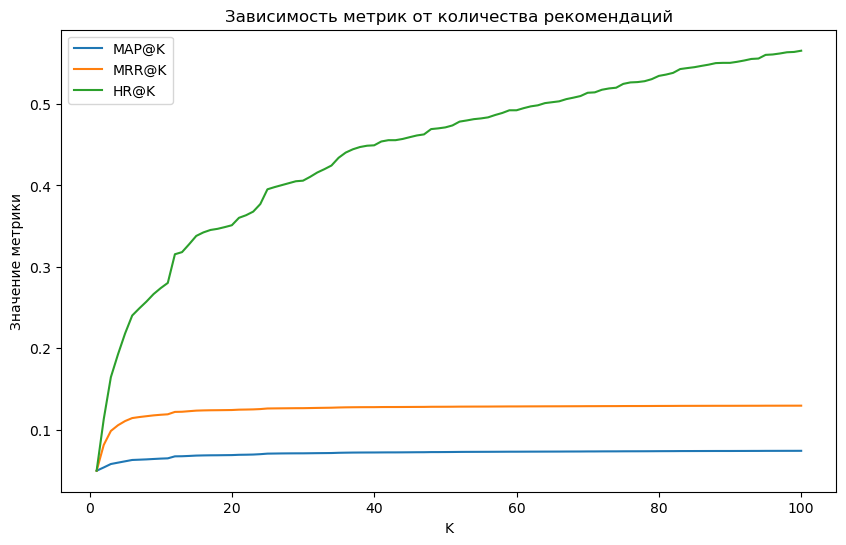

In [ ]:
toppop = TopPopular()
toppop.fit(joined)

ks = range(1, 101)
ap_scores = []
rr_scores = []
hr_scores = []

for k in ks:
    joined['tp_recs'] = toppop.predict(joined, topn=k)
    m = evaluate_recommender(joined, model_preds='tp_recs')
    ap_scores.append(m['map'])
    rr_scores.append(m['mrr'])
    hr_scores.append(m['hr'])

plt.figure(figsize=(10, 6))
plt.plot(ks, ap_scores, label='MAP@K')
plt.plot(ks, rr_scores, label='MRR@K')
plt.plot(ks, hr_scores, label='HR@K')
plt.xlabel('K')
plt.ylabel('Значение метрики')
plt.legend()
plt.title('Зависимость метрик от количества рекомендаций')
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**
* HR@K: является монотонно неубывающей функцией, так как при увеличении K вероятность попадания хотя бы одного релевантного айтема не уменьшается.
* MRR@K: зависит от ранга первого релевантного элемента; при K меньше ранга значение равно 0, а затем резко переходит к 1/рангу – поэтому функция имеет скачки, а не гладкую монотонность.
* MAP@K: не обязательно монотонна, так как добавление нерелевантных элементов может снизить среднюю точность, несмотря на увеличение K.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**
* График MAP@K отражает качество ранжирования по всем позициям – чем выше значение, тем лучше релевантность на всех позициях.
* График MRR@K показывает, насколько рано появляется первый релевантный элемент (чем выше – тем раньше).
* HR@K отражает вероятность того, что хотя бы один релевантный элемент присутствует в топ-K, что можно интерпретировать как шанс пользователя «увидеть» интересный контент при прокрутке ленты.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**
При небольших K метрики могут быть низкими, так как шанс попадания релевантного айтема невысок. При увеличении K HR@K растёт до 1, а MAP@K и MRR@K отражают баланс между точностью и шумом от нерелевантных элементов. Такие формы графиков часто наблюдаются из-за распределения интеракций и предпочтений пользователей.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [ ]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

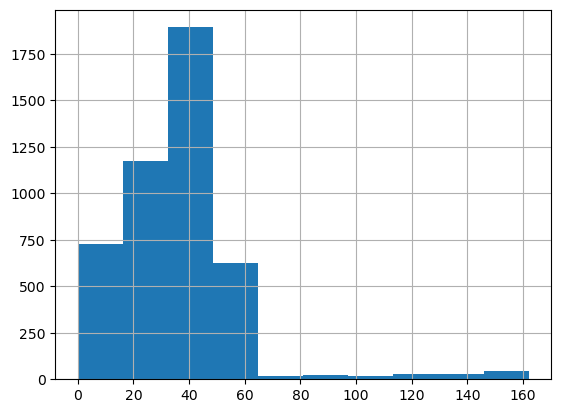

In [ ]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

   item_id                 title
0    10711        Поговори с ней
1     2508           Голые перцы
2    10716      Тактическая сила
3     7868                45 лет
4    16268  Все решает мгновение


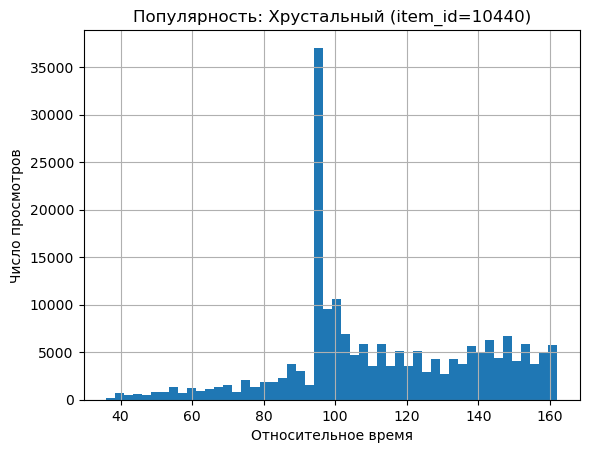

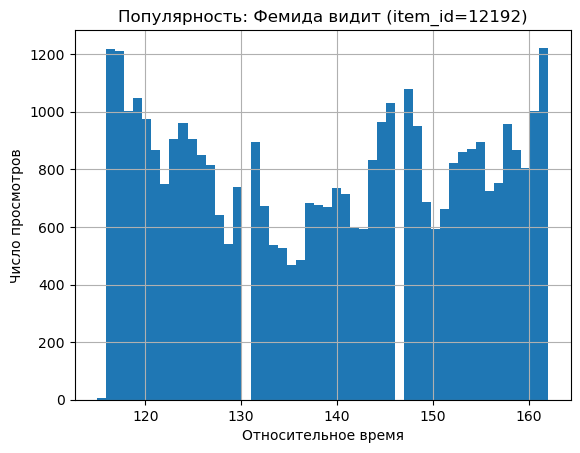

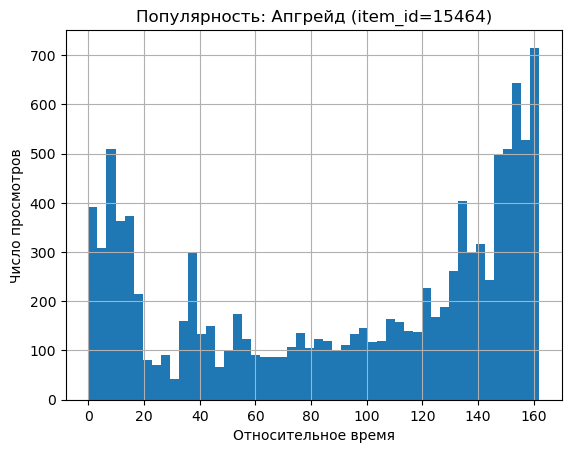

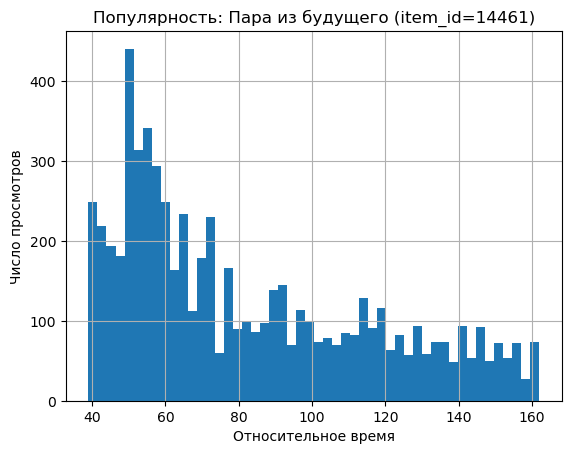

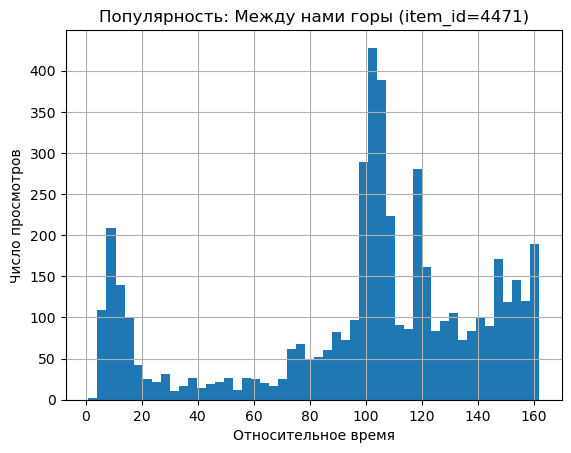

In [ ]:
items = pd.read_csv('items.csv')[['item_id', 'title']].copy()
print(items.head())

popular_items = df.item_id.value_counts()[:300].index.tolist()

sample_ids = [popular_items[0], popular_items[10], popular_items[50], popular_items[100], popular_items[150]]
for sid in sample_ids:
    interactions = df.loc[df.item_id == sid].copy()
    title = items.loc[items.item_id == sid, 'title'].values
    if title.size:
        title = title[0]
    else:
        title = f"item {sid}"
    plt.figure()
    interactions.last_watch_dt.hist(bins=50)
    plt.title(f'Популярность: {title} (item_id={sid})')
    plt.xlabel('Относительное время')
    plt.ylabel('Число просмотров')
    plt.show()

Сделал топ-300 фильмов. И взял 5 элементов (топ 1, топ 11, топ 51, топ 101, топ 151). На каждом фильме видны всплески популярности, которые могут быть из-за дополнительной рекламы или некого "признания публикой"

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [ ]:
def filter_column(df: pd.DataFrame, col: str, min_freq: int) -> pd.DataFrame:
    freq = df[col].value_counts()
    valid = freq[freq >= min_freq].index
    return df[df[col].isin(valid)].copy()

def filter_dataframe(df: pd.DataFrame, cols: List[str], min_freq: int = 5) -> pd.DataFrame:
    df_filtered = df.copy()
    while True:
        prev_shape = df_filtered.shape[0]
        for col in cols:
            df_filtered = filter_column(df_filtered, col, min_freq)
        if df_filtered.shape[0] == prev_shape:
            break
    return df_filtered

filtered_train = filter_dataframe(df, cols=['user_id', 'item_id'], min_freq=5)
print("Число интеракций после фильтрации:", filtered_train.shape[0])
print("Пользователей:", filtered_train.user_id.nunique(), "\nАйтемов:", filtered_train.item_id.nunique())


Число интеракций после фильтрации: 4278492
Пользователей: 302205 
Айтемов: 10031


In [ ]:
from scipy import sparse as sps

def df_encode(df):
    user2id = {k: v for v, k in enumerate(df.user_id.unique())}
    item2id = {k: v for v, k in enumerate(df.item_id.unique())}
    id2user = {v: k for k, v in user2id.items()}
    id2item = {v: k for k, v in item2id.items()}
    df = df.copy()
    df['user_id'] = df.user_id.map(user2id)
    df['item_id'] = df.item_id.map(item2id)
    return df, user2id, item2id, id2user, id2item

filtered_train, user2id, item2id, id2user, id2item = df_encode(filtered_train)
matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id))
)
matrix.shape

(302205, 10031)

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

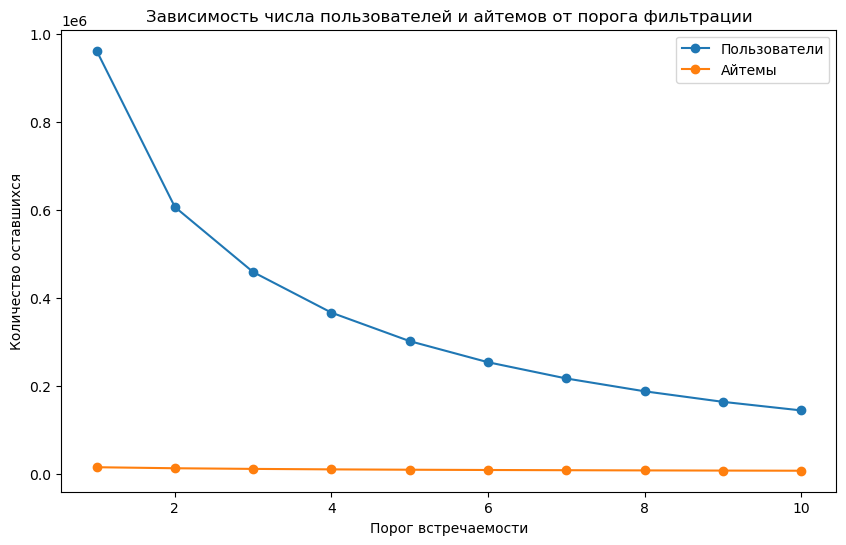

In [ ]:
freq_thresholds = range(1, 11)
users_counts = []
items_counts = []

for thresh in freq_thresholds:
    df_filt = filter_dataframe(df, cols=['user_id', 'item_id'], min_freq=thresh)
    users_counts.append(df_filt.user_id.nunique())
    items_counts.append(df_filt.item_id.nunique())

plt.figure(figsize=(10, 6))
plt.plot(freq_thresholds, users_counts, marker='o', label='Пользователи')
plt.plot(freq_thresholds, items_counts, marker='o', label='Айтемы')
plt.xlabel('Порог встречаемости')
plt.ylabel('Количество оставшихся')
plt.legend()
plt.title('Зависимость числа пользователей и айтемов от порога фильтрации')
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [ ]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=1000):
    G = X.T @ X
    G = G + reg_weight * sps.identity(G.shape[0])
    G = G.todense()
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    np.fill_diagonal(B, 0.)
    return B

w = fit_ease(matrix, reg_weight=1000)
print("Форма матрицы весов:", w.shape)

Форма матрицы весов: (10031, 10031)
CPU times: total: 3min 29s
Wall time: 40.1 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [ ]:
def get_preds(x, item2id, id2item, w, topn = 100):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:topn]

    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w, topn = 10))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,tpw_recs,tp_recs,ease_preds
0,106,"[(9335, 28), (312, 35), (11494, 35), (12965, 5...","[(12908, 159), (2836, 159), (12873, 159), (337...","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[16166, 7571, 3182, 10761, 16270, 6774, 13243,..."
1,109,"[(11047, 146)]","[(13492, 162), (10768, 162)]","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[12133, 12974, 11756, 12988, 12386, 4266, 1321..."
2,189,"[(5505, 144)]","[(12360, 155), (6898, 155), (4549, 160), (582,...","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[14899, 7597, 13849, 6162, 12356, 13464, 16415..."
3,373,"[(2154, 120)]","[(3734, 157)]","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[7107, 11237, 2388, 142, 13763, 5424, 14461, 8..."
4,409,"[(10440, 106), (15297, 106), (5424, 108), (863...","[(16509, 155)]","[8005, 11991, 297]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[15297, 9728, 10440, 3734, 13865, 4151, 12192,...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[4151, 13865, 15297, 10440, 9728, 142, 2657, 3..."


In [ ]:
metrics_ease = evaluate_recommender(joined, model_preds='ease_preds')
print("Метрики EASE:", metrics_ease)
print("Метрики TopPopular:", evaluate_recommender(joined, model_preds='toppopular_recs'))

Метрики EASE: {'map': 0.076807275, 'mrr': 0.14041416, 'hr': 0.316}
Метрики TopPopular: {'map': 0.07423744, 'mrr': 0.12964803, 'hr': 0.5653}


Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** В данном эксперименте TopPopular сработало лучше, судя по метрикам

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

reg: 100, metrics: {'map': 0.07708467, 'mrr': 0.1400898, 'hr': 0.3195}
reg: 178, metrics: {'map': 0.07713396, 'mrr': 0.14037381, 'hr': 0.3183}
reg: 316, metrics: {'map': 0.07670544, 'mrr': 0.13960183, 'hr': 0.3166}
reg: 562, metrics: {'map': 0.07663033, 'mrr': 0.13985044, 'hr': 0.3158}
reg: 1000, metrics: {'map': 0.076807275, 'mrr': 0.14041416, 'hr': 0.316}
reg: 1778, metrics: {'map': 0.07707046, 'mrr': 0.14132132, 'hr': 0.3139}
reg: 3162, metrics: {'map': 0.07780101, 'mrr': 0.14248084, 'hr': 0.3135}
reg: 5623, metrics: {'map': 0.078421384, 'mrr': 0.14380988, 'hr': 0.3124}
reg: 10000, metrics: {'map': 0.07937372, 'mrr': 0.1455908, 'hr': 0.3116}
reg: 17783, metrics: {'map': 0.08044812, 'mrr': 0.14709286, 'hr': 0.3141}
reg: 31623, metrics: {'map': 0.08105588, 'mrr': 0.14843118, 'hr': 0.3155}
reg: 56234, metrics: {'map': 0.0820689, 'mrr': 0.15022822, 'hr': 0.3179}
reg: 100000, metrics: {'map': 0.08298373, 'mrr': 0.1522722, 'hr': 0.3186}
reg: 177828, metrics: {'map': 0.08487201, 'mrr': 0.1

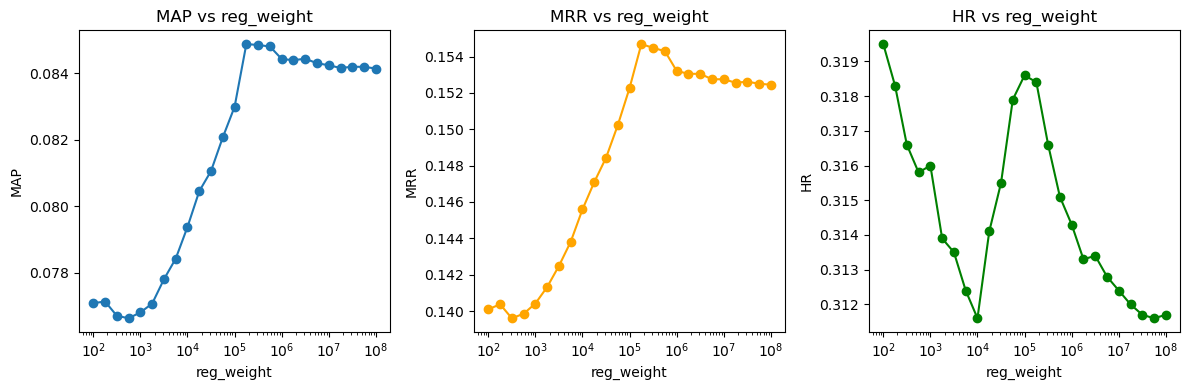

In [ ]:
reg_values = np.logspace(2, 8, num=25)
ease_metrics = {'reg': [], 'map': [], 'mrr': [], 'hr': []}

for reg in reg_values:
    w_tuned = fit_ease(matrix, reg_weight=reg)
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w_tuned, topn=10))
    metrics = evaluate_recommender(joined, model_preds='ease_preds')
    ease_metrics['reg'].append(reg)
    ease_metrics['map'].append(metrics['map'])
    ease_metrics['mrr'].append(metrics['mrr'])
    ease_metrics['hr'].append(metrics['hr'])
    print(f"reg: {reg:.0f}, metrics: {metrics}")

plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.semilogx(ease_metrics['reg'], ease_metrics['map'], marker='o')
plt.title('MAP vs reg_weight')
plt.xlabel('reg_weight')
plt.ylabel('MAP')

plt.subplot(1,3,2)
plt.semilogx(ease_metrics['reg'], ease_metrics['mrr'], marker='o', color='orange')
plt.title('MRR vs reg_weight')
plt.xlabel('reg_weight')
plt.ylabel('MRR')

plt.subplot(1,3,3)
plt.semilogx(ease_metrics['reg'], ease_metrics['hr'], marker='o', color='green')
plt.title('HR vs reg_weight')
plt.xlabel('reg_weight')
plt.ylabel('HR')

plt.tight_layout()
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?


**Ответ:**
* reg: 31623, metrics: {'map': 0.08105588, 'mrr': 0.14843118, 'hr': 0.3155}
  
* reg: 56234, metrics: {'map': 0.0820689, 'mrr': 0.15022822, 'hr': 0.3179}

* reg: 100000, metrics: {'map': 0.08298373, 'mrr': 0.1522722, 'hr': 0.3186}
  
* reg: 177828, metrics: {'map': 0.08487201, 'mrr': 0.15468912, 'hr': 0.3184}

* reg: 316228, metrics: {'map': 0.08484271, 'mrr': 0.1544781, 'hr': 0.3166}

* reg: 562341, metrics: {'map': 0.08479895, 'mrr': 0.15429772, 'hr': 0.3151}

Лучший map при reg = 177828

Лучший mrr при reg = 177828

Лучший hr при reg = 100000

Примем среднее значение reg = 177828 как лучшее

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** Графики показывают, что при увеличении параметра регуляции MAP и MRR постепенно растут. Это означает, что с увеличением reg модель становится более стабильной, лучше ранжирует результаты и правильные рекомендации оказываются выше в списке

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

In [ ]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):
    n_users = len(df)
    gt_lists = df[gt_col].apply(lambda lst: [x[0] if isinstance(x, (list, tuple)) else x for x in lst]).tolist()
    preds = df[model_preds].tolist()
    topn = len(preds[0])
    preds_matrix = np.array(preds)
    relevance = np.array([np.isin(preds_matrix[i], gt_lists[i]).astype(np.float32) for i in range(n_users)])

    gt_counts = np.array([len(gt) for gt in gt_lists])

    cumsum_rel = np.cumsum(relevance, axis=1)
    positions = np.arange(1, topn + 1, dtype=np.float32)
    precision_at_i = cumsum_rel / positions[None, :]
    norm = np.minimum(topn, gt_counts)
    norm_safe = np.where(norm == 0, 1, norm).astype(np.float32)

    AP = (relevance * precision_at_i).sum(axis=1) / norm_safe
    AP = np.where(gt_counts == 0, 0, AP)

    first_rel_pos = np.full(n_users, topn+1, dtype=np.int32)
    for i in range(n_users):
        rel_idx = np.where(relevance[i] == 1)[0]
        if rel_idx.size:
            first_rel_pos[i] = rel_idx[0] + 1
    RR = 1 / first_rel_pos.astype(np.float32)
    RR = np.where(first_rel_pos > topn, 0, RR)
    HR = (relevance.sum(axis=1) > 0).astype(np.float32)
    metrics = {'map': np.mean(AP), 'mrr': np.mean(RR), 'hr': np.mean(HR) }
    return metrics


Прошло 1.683235168457031e-05 минут. DEBUG mf = 3
Прошло 1.802524697780609 минут. DEBUG top = 1
Прошло 47.884188715616865 минут. DEBUG top = 21
Прошло 93.92745182116826 минут. DEBUG top = 41
Прошло 139.7769052942594 минут. DEBUG top = 61
Прошло 185.91278950770695 минут. DEBUG top = 81
Прошло 232.88975435098013 минут. DEBUG mf = 5
Прошло 234.26408117612203 минут. DEBUG top = 1
Прошло 260.3144278168678 минут. DEBUG top = 21
Прошло 286.8582857688268 минут. DEBUG top = 41
Прошло 313.30851523081463 минут. DEBUG top = 61
Прошло 339.6799679438273 минут. DEBUG top = 81
Прошло 366.1495414495468 минут. DEBUG mf = 7
Прошло 367.01371120214463 минут. DEBUG top = 1
Прошло 383.94285217126213 минут. DEBUG top = 21
Прошло 400.77910815874736 минут. DEBUG top = 41
Прошло 417.85447590351106 минут. DEBUG top = 61
Прошло 434.69223812421166 минут. DEBUG top = 81


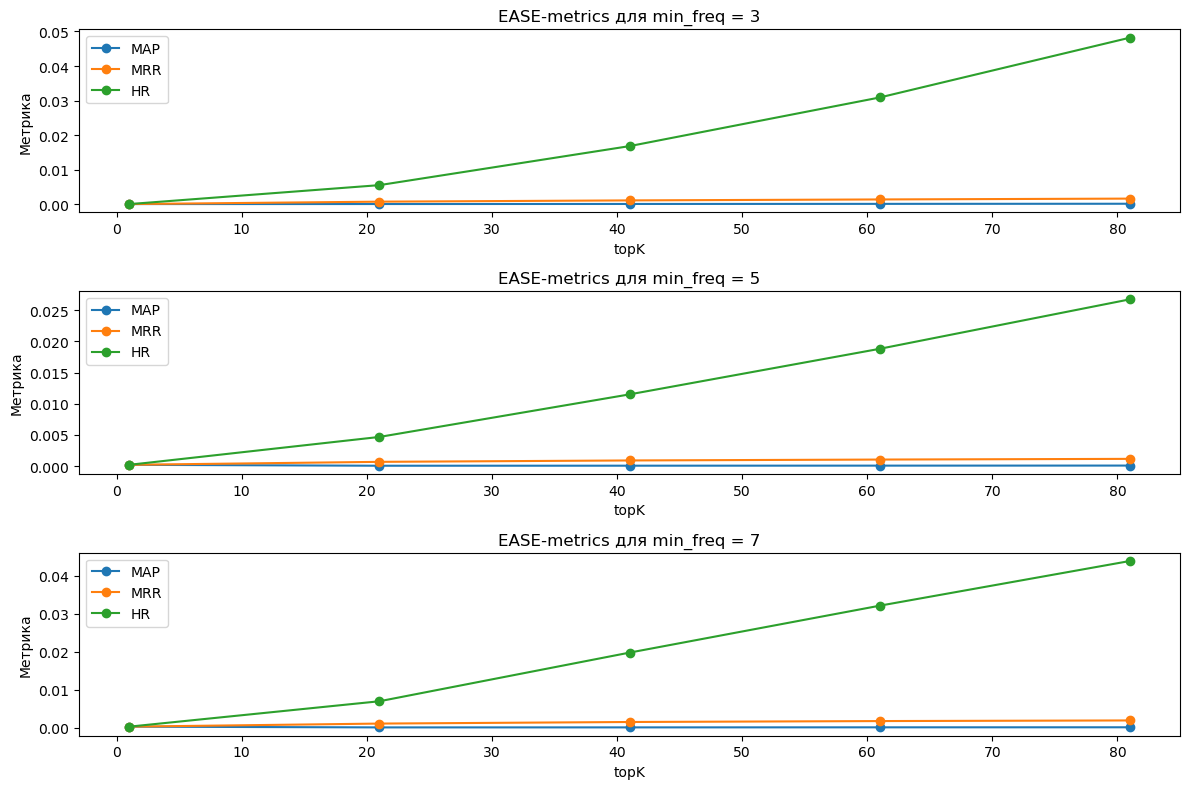

In [ ]:
import time

min_freq_list = [3, 5, 7]
topk_range = range(1, 101, 20)

plt.figure(figsize=(12, 8))
time0 = time.time()
for mf in min_freq_list:
    print(f"Прошло {(time.time() - time0)/60} минут. DEBUG mf = {mf}")
    df_filtered_temp = filter_dataframe(df, cols=['user_id', 'item_id'], min_freq=mf)
    df_encoded, user2id_temp, item2id_temp, id2user_temp, id2item_temp = df_encode(df_filtered_temp)
    matrix_temp = sps.coo_matrix(
        (np.ones(df_encoded.shape[0]), (df_encoded['user_id'], df_encoded['item_id'])),
        shape=(len(user2id_temp), len(item2id_temp))
    )
    w_temp = fit_ease(matrix_temp, reg_weight=1000)

    user_interactions = df_encoded.groupby('user_id').apply(lambda x: list(x.item_id)).reset_index().rename(columns={0:'train_interactions'})
    user_interactions['test_interactions'] = user_interactions['train_interactions']
    joined_temp = user_interactions.copy()

    map_scores_k = []
    mrr_scores_k = []
    hr_scores_k = []
    for k in topk_range:
        print(f"Прошло {(time.time() - time0)/60} минут. DEBUG top = {k}")
        joined_temp['ease_preds'] = joined_temp['train_interactions'].apply(
            lambda x: get_preds([(item, 0) for item in x], item2id_temp, id2item_temp, w_temp, topn=k)
        )
        # print(joined_temp['train_interactions'])
        metrics = evaluate_recommender(joined_temp, model_preds='ease_preds', gt_col='test_interactions')
        map_scores_k.append(metrics['map'])
        mrr_scores_k.append(metrics['mrr'])
        hr_scores_k.append(metrics['hr'])
    plt.subplot(3, 1, min_freq_list.index(mf)+1)
    plt.plot(topk_range, map_scores_k, marker='o', label='MAP')
    plt.plot(topk_range, mrr_scores_k, marker='o', label='MRR')
    plt.plot(topk_range, hr_scores_k, marker='o', label='HR')
    plt.title(f'EASE-metrics для min_freq = {mf}')
    plt.xlabel('topK')
    plt.ylabel('Метрика')
    plt.legend()

plt.tight_layout()
plt.show()

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**
Графики подтверждают гипотезу, выдвинутую в лекции: ослабление фильтра (снижение min_freq) приводит к улучшению качества рекомендаций, так как в процесс включается больше информации о пользователях и фильмах. Увеличение topK повышает вероятность того, что релевантные фильмы попадут в список рекомендаций

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.



In [ ]:
def get_item2item_recommendations(item_id, item2id, id2item, w, topn=5):
    if item_id not in item2id:
        return []
    idx = item2id[item_id]
    scores = np.array(w[idx]).flatten()
    scores[idx] = -np.inf
    top_indices = np.argsort(-scores)[:topn]
    recommended_item_ids = [id2item[i] for i in top_indices]
    return recommended_item_ids

random.seed(42)

sampled_item_ids = random.sample(list(item2id.keys()), 10)

for item in sampled_item_ids:
    rec_ids = get_item2item_recommendations(item, item2id, id2item, w, topn=5)
    base_title_arr = items_df.loc[items_df['item_id'] == item, 'title'].values
    base_title = base_title_arr[0] if len(base_title_arr) > 0 else str(item)
    rec_titles = []
    for rec in rec_ids:
        rec_title_arr = items_df.loc[items_df['item_id'] == rec, 'title'].values
        rec_title = rec_title_arr[0] if len(rec_title_arr) > 0 else str(rec)
        rec_titles.append(rec_title)
    print(f"Рекомендации для '{base_title}' (ID: {item}):")
    for i, title in enumerate(rec_titles, start=1):
        print(f"  {i}. {title}")
    print()

Рекомендации для 'Праздник Клаудии' (ID: 12175):
  1. Праздник Клаудии (полная версия)
  2. Шалости
  3. Женские губы
  4. Маленькие куколки
  5. Соблазн

Рекомендации для 'Азнавур' (ID: 15942):
  1. Пальмира
  2. Немцы
  3. Сахаров. Две жизни
  4. Фемида видит
  5. Спорт XX века

Рекомендации для 'Горячие латинские киски' (ID: 15868):
  1. Азиатские J-Pop девочки
  2. 10 сексуальных милашек
  3. Восемнадцатилетние развратницы
  4. Горячо по веб-камере
  5. Внутри меня 1

Рекомендации для 'Не отпускай мою руку' (ID: 14092):
  1. Жестокий Стамбул
  2. Хрустальный
  3. Столкновение
  4. Люби меня таким
  5. Дуров

Рекомендации для 'Крыша мира' (ID: 13999):
  1. Медиатор
  2. Вампиры средней полосы
  3. Фитнес
  4. Война семей
  5. День города

Рекомендации для 'Глубоководный горизонт' (ID: 7474):
  1. Экипаж
  2. Явление
  3. Дело храбрых
  4. Страховщик
  5. Во власти стихии

Рекомендации для 'Под маской жиголо' (ID: 13744):
  1. Простые сложности
  2. Клиника счастья
  3. Соседи сверху

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** На первый взгляд, рекомендации выглядят логичными. Везде есть какая то общая тематика. К примеру тема "романтика":

Рекомендации для 'Все возрасты любви' (ID: 6171):
  1. Обними меня
  2. Клиника счастья
  3. Секреты семейной жизни
  4. Лето - это море
  5. Запретная любовьюбовь